In [1]:
cd ..

/mnt/wsl/PHYSICALDRIVE2p4/projects/repertoire_classification


In [2]:
pwd

'/mnt/wsl/PHYSICALDRIVE2p4/projects/repertoire_classification'

In [3]:
from src.repertoire import repertoire_dataset_loader
from src.methods.motif import MotifClassifier
import numba
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
import copy


In [4]:
repertoires = repertoire_dataset_loader("./data/interim/repertoires/","Emerson")

RepertoireLoader_Multi: 100%|██████████| 760/760 [00:29<00:00, 26.10it/s]


In [5]:
from typing import List, Optional
import numpy as np
from src.util import human_amino_acids, basic_void_mark
def trigram_features(
    seqs: List[str],
    alphabets: Optional[List[str]] = None,
    void_mark: Optional[str] = None,
    count_weights: Optional[List[int]] = None,
):  # int8 matrix value range: (0-20), shape :,32
    """
        Returns a feature vector, that each dimension represents a tri-mer.
        if count_weights is given, the feature is weighted by duplicate counts.
        If tfidf_weights is given, the features are converted by tfidf (a seq is seen as a doc)
    :param seqs:
    :param alphabets:
    :param void_mark:
    :param count_weights:
    :return:
    """
    if alphabets is None:
        alphabets = human_amino_acids
    if void_mark is None:
        void_mark = basic_void_mark
    if count_weights is None:
        count_weights = [1] * len(seqs)
    alphabets_with_void = [void_mark] + alphabets
    alphabet_size = len(alphabets_with_void)
    index2aa = dict(enumerate(alphabets_with_void))
    aa2index = {val: key for key, val in index2aa.items()}

    n = len(seqs)
    count_weights = np.array(count_weights,dtype=np.int64)
    seq_arrs = []
    for p in range(n):
        seq = [void_mark] + list(seqs[p]) + [void_mark]
        seq_arrs.append(np.array([aa2index[s] for s in seq]))
    return trigram(seq_arrs,alphabet_size,count_weights)

@numba.jit(nopython=True)
def trigram(seq_arrs:List[np.array],alphabet_size:int,count_weights:np.array):
    n = len(seq_arrs)
    arrays = np.zeros((n, alphabet_size ** 3), dtype=np.int64)
    for p in range(n):
        seq_arr = seq_arrs[p]
        for q in range(0, len(seq_arr) - 2):
            # no weight by counts
            arrays[
                p,
                seq_arr[q] * alphabet_size ** 2
                + seq_arr[q + 1] * alphabet_size ** 1
                + seq_arr[q + 2] * alphabet_size ** 0,
            ] += (
                1 * count_weights[p]
            )
    # np.ndarray.sum returns int
    reduced = arrays.sum(axis=0) # to cache
    return reduced


In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm
from src.repertoire import Repertoire

def trigram_features_wrapper(r):
    return trigram_features(r["seq"],human_amino_acids, basic_void_mark, r["cnt"]) 

features =  Parallel(n_jobs=3)(delayed(trigram_features_wrapper)({"seq":r.sequences.get_all(),"cnt":r.counts}) for r in tqdm(repertoires))

100%|██████████| 760/760 [39:05<00:00,  3.09s/it]


In [7]:
cmv = [r.info["CMV"] for r in repertoires]

In [8]:
cmv[:10]

[False, False, True, False, False, False, True, False, False, False]

In [9]:
features = np.array(features)

In [10]:
features

array([[  0,   0,   0, ..., 267,   0, 309],
       [  0,   0,   0, ...,  34,  33,  62],
       [  0,   0,   0, ...,   0,  24, 126],
       ...,
       [  0,   0,   0, ...,   7,   4,  38],
       [  0,   0,   0, ...,  12,  22,  54],
       [  0,   0,   0, ...,  13,  12,  44]])

In [11]:
np.all(features >= 0) 

True

In [12]:
occurance_df = pd.DataFrame.from_dict({str(x):features[:,x] for x in range(features.shape[1])})
features2 = features / features.sum(axis=1).reshape(features.shape[0],1)
normalized_df = pd.DataFrame.from_dict({str(x):features2[:,x] for x in range(features2.shape[1])})

In [13]:
occurance_df["cmv"] = cmv
normalized_df["cmv"] = cmv

In [14]:
occurance_df["sample_id"] = [r.sample_id for r in repertoires]
normalized_df["sample_id"] = [r.sample_id for r in repertoires]

In [15]:
occurance_df["cohort"] = occurance_df["sample_id"].str[:3]
normalized_df["cohort"] = normalized_df["sample_id"].str[:3]

In [16]:
occurance_df

,0,1,2,3,4,5,6,7,8,9,...,9254,9255,9256,9257,9258,9259,9260,cmv,sample_id,cohort
0,0,0,0,0,0,0,0,0,0,0,...,152,829,286,427,267,0,309,False,HIP00110,HIP
1,0,0,0,0,0,0,0,0,0,0,...,129,238,303,202,34,33,62,False,HIP00169,HIP
2,0,0,0,0,0,0,0,0,0,0,...,126,216,256,443,0,24,126,True,HIP00594,HIP
3,0,0,0,0,0,0,0,0,0,0,...,909,848,1381,1345,52,6,487,False,HIP00602,HIP
4,0,0,0,0,0,0,0,0,0,0,...,87,291,256,158,0,3,84,False,HIP00614,HIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0,0,0,0,0,0,0,0,0,0,...,28,104,84,84,9,4,56,False,Keck0116,Kec
756,0,0,0,0,0,0,0,0,0,0,...,26,50,86,73,5,9,24,True,Keck0117,Kec
757,0,0,0,0,0,0,0,0,0,0,...,34,60,74,80,7,4,38,True,Keck0118,Kec
758,0,0,0,0,0,0,0,0,0,0,...,35,73,84,99,12,22,54,True,Keck0119,Kec


In [17]:
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,9254,9255,9256,9257,9258,9259,9260,cmv,sample_id,cohort
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.000018,0.000006,0.000009,5.715483e-06,0.000000e+00,0.000007,False,HIP00110,HIP
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000008,0.000014,0.000018,0.000012,2.057574e-06,1.997058e-06,0.000004,False,HIP00169,HIP
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000006,0.000007,0.000013,0.000000e+00,6.980441e-07,0.000004,True,HIP00594,HIP
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000008,0.000008,0.000013,0.000012,4.740137e-07,5.469389e-08,0.000004,False,HIP00602,HIP
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000013,0.000011,0.000007,0.000000e+00,1.308060e-07,0.000004,False,HIP00614,HIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000015,0.000012,0.000012,1.262172e-06,5.609651e-07,0.000008,False,Keck0116,Kec
756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000007,0.000012,0.000010,6.835579e-07,1.230404e-06,0.000003,True,Keck0117,Kec
757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000004,0.000006,0.000008,0.000008,7.375910e-07,4.214806e-07,0.000004,True,Keck0118,Kec
758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.000010,0.000012,0.000014,1.707563e-06,3.130532e-06,0.000008,True,Keck0119,Kec


In [19]:
# only use normalized_df / occurance_df after here

In [20]:
# GPLVM

In [21]:
X = np.array(normalized_df[[str(x) for x in range(9261)]])

In [22]:
(X >= 0).all()

True

In [23]:
input_dim = 2
X = np.array(normalized_df[[str(x) for x in range(9261)]])
kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Bias(input_dim) + GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim)
model = GPy.models.BayesianGPLVM(X, input_dim, kernel=kernel, num_inducing=30)
model.optimize(messages=True, max_iters=5e3)

In [24]:
model.latent_space.parameters

[bayesian_gplvm.latent_space.mean:
 Param([[-0.07901343,  0.86480046],
        [ 0.49489923,  1.57887197],
        [-1.55973416,  0.939823  ],
        ...,
        [-0.6332098 , -2.19195044],
        [ 0.63318296, -1.42332083],
        [ 0.85612723, -0.68514929]]),
 bayesian_gplvm.latent_space.variance:
 Param([[0.04547715, 0.04915256],
        [0.04064509, 0.0092435 ],
        [0.01981256, 0.06037966],
        ...,
        [0.04241867, 0.00139197],
        [0.04971555, 0.03570962],
        [0.03806807, 0.04785354]])]

In [25]:
means = model.latent_space.parameters[0]

In [26]:
visualize_df = pd.DataFrame.from_dict({"x": means[:,0],"y": means[:,1],"cmv":normalized_df["cmv"],"cohort":normalized_df["cohort"]})


In [27]:
plot_df = copy.deepcopy(visualize_df)
plot_df["CMV"] = ["Positive" if x else "Negative" for x in plot_df["cmv"] ]
del plot_df["cmv"]
plot_df["Cohort"] = ["Large" if x=="HIP" else "Small" for x in plot_df["cohort"] ]
del plot_df["cohort"]

In [36]:
def make_hue(cmv,cohort):
    if cmv and cohort=="HIP":
        return "Positive/Cohort 1"
    elif cmv:
        return "Positive/Cohort 2"
    elif cohort=="HIP":
        return "Negative/Cohort 1"
    else:
        return "Negative/Cohort 2"


plot_df["CMV/Cohort"] = [make_hue(x,y) for x,y in zip(visualize_df["cmv"],visualize_df["cohort"])] 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


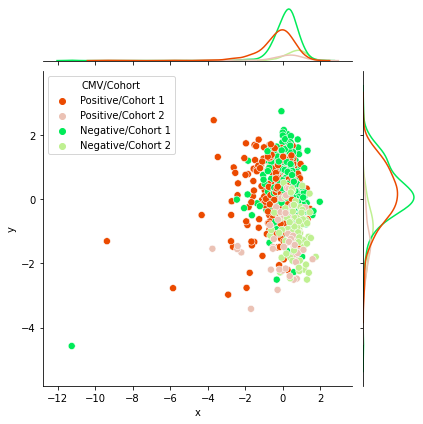

In [41]:
ax = sns.jointplot(data=plot_df,x="x",y="y",hue="CMV/Cohort",s=50,
hue_order=["Positive/Cohort 1","Positive/Cohort 2","Negative/Cohort 1","Negative/Cohort 2"],
palette={"Positive/Cohort 1":"#EB4A00","Positive/Cohort 2":"#EBC2B5","Negative/Cohort 1":"#00EB58","Negative/Cohort 2":"#BFF091"},marginal_kws={"fill":False})#,xlabel="Axis 1",ylabel="Axis 2")
# ax.legend(loc="upper left")
ax.fig.savefig("210830_unsupervised.eps")

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(~visualize_df["cmv"],np.array(means[:,0])),roc_auc_score(~visualize_df["cmv"],np.array(means[:,1]))

(0.6828011204481794, 0.5274299719887955)

In [40]:
roc_auc_score(visualize_df["cohort"]!="HIP",np.array(means[:,0])),roc_auc_score(visualize_df["cohort"]=="HIP",np.array(means[:,1]))

(0.7035416666666666, 0.87375)

In [31]:
roc_auc_score(visualize_df["cohort"]=="HIP",np.array(means[:,0])),roc_auc_score(~(visualize_df["cohort"]=="HIP"),np.array(means[:,1]))

(0.2964583333333333, 0.12625000000000003)

In [32]:
# @coHORTWISE NO BUNBETUSNOU
roc_auc_score(~visualize_df[visualize_df["cohort"]=="HIP"]["cmv"],np.array(means[visualize_df["cohort"]=="HIP",0])),roc_auc_score(visualize_df[visualize_df["cohort"]=="HIP"]["cmv"],np.array(means[visualize_df["cohort"]=="HIP",1]))

(0.6833170674001123, 0.4730133380652412)

In [33]:
from scipy.stats import spearmanr
import numpy as np
spearmanr(visualize_df["cohort"]=="HIP",np.array(means[:,0])),spearmanr(~(visualize_df["cohort"]=="HIP"),np.array(means[:,1]))

(SpearmanrResult(correlation=-0.2571054857216041, pvalue=6.12906576664836e-13),
 SpearmanrResult(correlation=-0.47210567183680424, pvalue=1.9060750410141054e-43))

In [34]:
spearmanr(~visualize_df["cmv"],np.array(means[:,0])),spearmanr(~visualize_df["cmv"],np.array(means[:,1]))

(SpearmanrResult(correlation=0.31486208264531707, pvalue=5.946414458513073e-19),
 SpearmanrResult(correlation=0.047246198962676476, pvalue=0.19323430245745185))